# Calling the Instance Segmentation deployed model

In [1]:
import base64
import json
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import os
import ssl
import warnings

from IPython.display import Image
from matplotlib.lines import Line2D
from PIL import Image as PILimage

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()
    
def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

In [3]:
def get_predictions(imagefile):

    data =  {
        "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(imagefile)).decode("utf-8")],
      }
    }

    body = str.encode(json.dumps(data))

    if not api_key:
        raise Exception("A key should be provided to invoke the endpoint")

    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key),
               'azureml-model-deployment': 'instance-mlflow-model-dpl' }
    req = urllib.request.Request(url, body, headers)

    try:
        response = urllib.request.urlopen(req)
        resp = response.read()
        return resp

    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))
        print(error.info())
        print(error.read().decode("utf8", 'ignore'))

In [4]:
def view_predictions(minconf=0.5):
    """
    Viewing predictions
    """
    img_np = mpimg.imread(sample_image)
    img = PILimage.fromarray(img_np.astype("uint8"), "RGB")
    x, y = img.size

    fig, ax = plt.subplots(1, figsize=(15, 15))

    ax.imshow(img_np)
    nb_product = 0

    print("AutoML for instance segmentation results:\n")

    detections = json.loads(resp)[0]

    for detect in detections["boxes"]:
        label = detect["label"]
        box = detect["box"]
        polygon = detect["polygon"]
        conf_score = detect["score"]

        if conf_score >= minconf:
            ymin, xmin, ymax, xmax = (
                box["topY"],
                box["topX"],
                box["bottomY"],
                box["bottomX"],
            )
            topleft_x, topleft_y = x * xmin, y * ymin
            width, height = x * (xmax - xmin), y * (ymax - ymin)
            print(nb_product+1, "label:", label, "=", conf_score)
        
            if label == 'carton':
                color = "brown"

            if label == 'milk_bottle':
                color = "lime"

            if label == 'water_bottle':
                color = "cyan"
        
            if label == 'can':
                color = "orange"
            
            polygon_np = np.array(polygon[0])
            polygon_np = polygon_np.reshape(-1, 2)
            polygon_np[:, 0] *= x
            polygon_np[:, 1] *= y
            poly = patches.Polygon(polygon_np, True, facecolor=color, alpha=0.6)
        
            plt.text(np.min(polygon_np), np.max(polygon_np)+25, label + " = " + str(round(conf_score, 3)),
                     color=color, fontsize=20)
        
            ax.add_patch(poly)
            poly_line = Line2D(
                polygon_np[:, 0],
                polygon_np[:, 1],
                linewidth=2,
                marker="o",
                markersize=10,
                color=color,
                markerfacecolor=color,
            )
            ax.add_line(poly_line)
            nb_product += 1

    plt.text(25, 25, "Number of products = " + str(nb_product),
                     color="red", fontsize=25)

    plt.show()

## Credentials

In [8]:
from configparser import ConfigParser

configazurecs = ConfigParser()
print("Reading credentials from the file...")
print(configazurecs.read('instsegmodel.py'))

api_key = configazurecs['InstanceSegModel']['key']
url = configazurecs['InstanceSegModel']['endpoint']

Reading credentials from the file...
['instsegmodel.py']


## Testing

In [10]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "35.jpg")

In [11]:
resp = get_predictions(sample_image)
print(resp)

b'[{"filename": "/tmp/tmp74x_ab6h/tmp2p5ov3d_", "boxes": [{"box": {"topX": 0.0, "topY": 0.0, "bottomX": 0.3798970209343711, "bottomY": 0.8244895470287605}, "label": "water_bottle", "score": 0.9971241354942322, "polygon": [[0.28410513141426785, 0.823805060918463, 0.2428035043804756, 0.8228678537956888, 0.22403003754693368, 0.8209934395501406, 0.2190237797246558, 0.8191190253045924, 0.21026282853566958, 0.8116213683223993, 0.20525657071339173, 0.8022492970946579, 0.1927409261576971, 0.7919400187441424, 0.18523153942428036, 0.781630740393627, 0.17772215269086358, 0.7647610121836926, 0.17271589486858574, 0.746954076850984, 0.1677096370463079, 0.7385192127460168, 0.16145181476846057, 0.711340206185567, 0.1539424280350438, 0.6935332708528584, 0.14893617021276595, 0.6532333645735707, 0.14017521902377972, 0.6288659793814433, 0.13642052565707133, 0.598875351452671, 0.13266583229036297, 0.5838800374882849, 0.1276595744680851, 0.5735707591377694, 0.1251564455569462, 0.5604498594189316, 0.12390488

AutoML for instance segmentation results:

1 label: water_bottle = 0.9971241354942322
2 label: can = 0.9736300706863403
3 label: milk_bottle = 0.9668684601783752


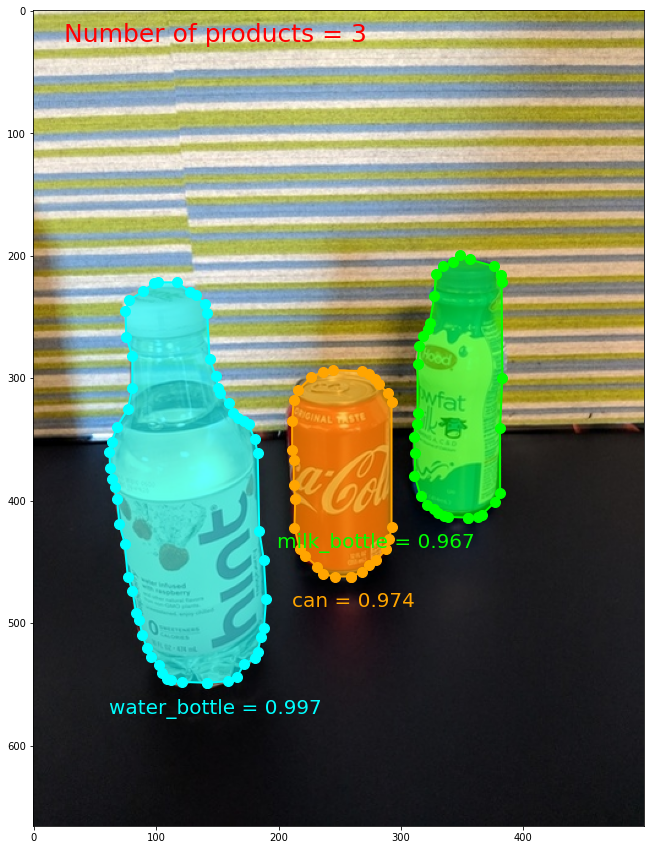

In [12]:
view_predictions()

In [22]:
sample_image = os.path.join("data/odFridgeObjectsMask/images", "85.jpg")

In [23]:
resp = get_predictions(sample_image)

AutoML for instance segmentation results:

1 label: carton = 0.989032506942749
2 label: can = 0.9795103669166565
3 label: water_bottle = 0.9648314118385315
4 label: milk_bottle = 0.9634506702423096


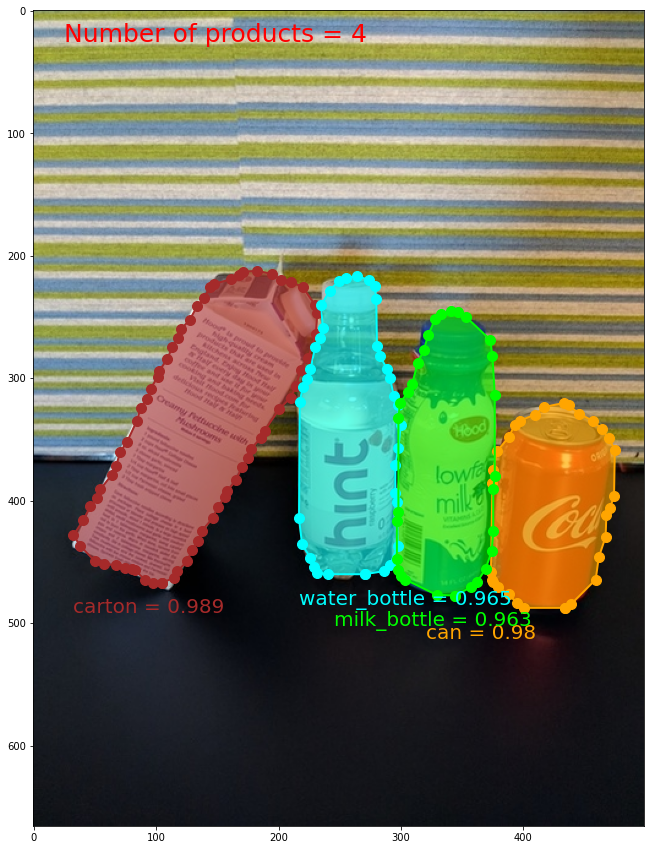

In [24]:
view_predictions()